In [65]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated, Literal
import operator
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from tqdm import tqdm

In [66]:
load_dotenv()

True

In [ ]:
llm = HuggingFaceEndpoint(
    repo_id='meta-llama/Llama-3.3-70B-Instruct',
    task="text-generation",
    max_new_tokens=2048,
)

generator_model = ChatHuggingFace(llm = llm)

llm2 = HuggingFaceEndpoint(
    repo_id='Qwen/Qwen2.5-72B-Instruct',
    task='text-generation',
    max_new_tokens=2048
)

evaluation_model = ChatHuggingFace(llm=llm2)

# evaluation_model = ChatGoogleGenerativeAI(
#     model='gemini-2.5-flash-lite'
# )

llm3 = HuggingFaceEndpoint(
    repo_id='MiniMaxAI/MiniMax-M2.1',
    task='text_generation',
    max_new_tokens=2048
)

optimizer_model = ChatHuggingFace(llm=llm3)

# optimizer_model = ChatGoogleGenerativeAI(
#     model='gemini-2.5-pro'
# )

In [68]:
search = DuckDuckGoSearchRun()

tool_generator_model = generator_model.bind_tools([search])

In [69]:
class TweetEvaluationSchema(BaseModel):
    evaluation: Literal['approved', 'needs_improvement'] = Field(description='Final evaulation result.')
    feedback: str = Field(description='Feedback for the tweet.')

structured_evaluation_model = evaluation_model.with_structured_output(TweetEvaluationSchema)

In [70]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal['approved', 'needs_improvement']
    feedback: str
    iteration: int
    max_iterations: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [88]:
def generate_tweet(state: TweetState) -> dict:

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
        Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

        use tool 'search' to search about latest information about "{state['topic']}"

        Rules:
        - Do NOT use question-answer format.
        - Max 280 characters.
        - Use observational humor, irony, sarcasm, or cultural references.
        - Think in meme logic, punchlines, or relatable takes.
        - Use simple, day to day english
        """)
    ]

    # send generator_llm
    response = tool_generator_model.invoke(messages)
    messages.append(response)
    for tool_call in response.tool_calls:
        tool_result = search.invoke(tool_call)
        messages.append(tool_result)

    final_response = tool_generator_model.invoke(messages).content
    print('generate step')
    print(final_response)
    return {'tweet': final_response, 'tweet_history': [final_response]}

In [89]:
def evaluate_tweet(state: TweetState) -> dict:

    # prompt
    messages = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
        HumanMessage(content=f"""
        Evaluate the following tweet:

        Tweet: "{state['tweet']}"

        Use the criteria below to evaluate the tweet:

        1. Originality - Is this fresh, or have you seen it a hundred times before?  
        2. Humor - Did it genuinely make you smile, laugh, or chuckle?  
        3. Punchiness - Is it short, sharp, and scroll-stopping?  
        4. Virality Potential - Would people retweet or share it?  
        5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

        Auto-reject if:
        - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
        - It exceeds 280 characters
        - It reads like a traditional setup-punchline joke
        - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

        ### Respond ONLY in structured format:
        - evaluation: "approved" or "needs_improvement"  
        - feedback: One paragraph explaining the strengths and weaknesses 
        """)
    ]
    print('evaluate step')
    response = structured_evaluation_model.invoke(messages)
    print(response)

    return {'evaluation': response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [90]:
def optimize_tweet(state: TweetState) -> dict:

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
        Improve the tweet based on this feedback:
        "{state['feedback']}"

        Topic: "{state['topic']}"
        Original Tweet:
        {state['tweet']}

        Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
        """)
    ]
    print('optimize step')
    response = optimizer_model.invoke(messages).content
    iteration = state['iteration'] + 1
    print(iteration)
    return {'response': response, 'iteration': iteration, 'tweet_history': [response]}

In [91]:
def route_evaluation(state: TweetState) -> Literal['approved', 'needs_improvements']:
    if state['evaluation'] == 'approved' or state['iteration'] > state['max_iterations']:
        return 'approved'
    else :
        return 'needs_improvements'

In [92]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvements': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

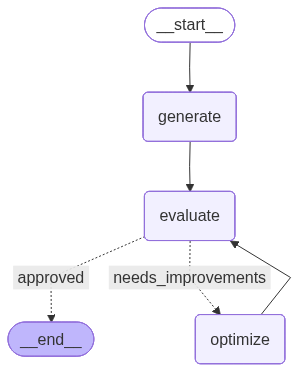

In [93]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [94]:
initial_state = {
    'topic': 'elonmusk',
    'iteration': 1,
    'max_iterations': 3
}

final_state = workflow.invoke(initial_state)

generate step
"Elon Musk's new AI assistant is so smart, it's already planning to take over the world... just like his Twitter account" #ElonMusk #AI
evaluate step
evaluation='needs_improvement' feedback="This tweet adheres to the technical format requirements and delivers a somewhat punchy observation. However, the humor is merely mild, relying heavily on the well-worn trope of AI world domination combined with a commonly held, albeit relevant, public sentiment regarding Elon Musk's management of Twitter. While the combination offers a slight twist, it lacks true originality and doesn't provide a fresh comedic perspective, limiting its potential for genuine laughter or widespread virality beyond those already aligned with the sentiment. To be truly effective, it needs a more inventive angle that transcends predictable commentary."
optimize step
2
evaluate step
evaluation='needs_improvement' feedback="This tweet attempts humor by connecting a common AI trope with the current public per

In [95]:
final_state

{'topic': 'elonmusk',
 'tweet': '"Elon Musk\'s new AI assistant is so smart, it\'s already planning to take over the world... just like his Twitter account" #ElonMusk #AI',
 'evaluation': 'approved',
 'feedback': "This tweet effectively leverages current events and a prominent figure's known eccentricities for a concise and humorous observation. The joke, comparing an AI's world domination to Elon Musk's control over his own Twitter account, is well-structured and punchy, making it easily digestible and shareable. While the 'AI taking over' trope isn't novel, its specific application here provides enough of a fresh twist to land the humor. It perfectly adheres to tweet formatting rules and has good viral potential due to its topical nature and sharp, relevant jab.",
 'iteration': 4,
 'max_iterations': 3,
 'tweet_history': ['"Elon Musk\'s new AI assistant is so smart, it\'s already planning to take over the world... just like his Twitter account" #ElonMusk #AI',
  'Here\'s a fresh take: